# ***Project - Unplanned stops prediction***

In [53]:
import arviz as az
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from cmdstanpy import CmdStanModel


# GLOBAL CONSTANTS
SEED = 29042020
REFRESH = 1000
BINS = 30

## 1. Problem formulation

This project aims to develop predictive models for forecasting unplanned stops in a production process. The prediction of unplanned stops can aid in proactive maintenance planning, resource allocation, and overall optimization of the production process. Two models will be considered: a gamma distribution model and a linear model. These models will utilize two input variables, namely cycle times and production counters, to predict the occurrence and duration of unplanned stops.

The selection of these models is driven by the need to capture different aspects of the relationship between the input variables and the outcome variable of unplanned stops. The gamma distribution model is chosen to account for the non-negativity of the response variable and potential skewness in the data. Conversely, the linear model is chosen to explore the assumption of a linear relationship between the input variables and the response.

The cycle times variable represents the time taken to complete one production cycle, while the production counters variable indicates the number of units produced during a specific period. Both variables are expected to influence the occurrence and duration of unplanned stops. By incorporating these variables into the models, this study aims to understand their impact on unplanned stops and utilize this knowledge to make accurate predictions.

Throughout this project, statistical techniques will be employed, and the Stan modeling language will be used to develop and estimate the parameters of the gamma distribution model and the linear model. Historical data on cycle times, production counters, and corresponding unplanned stops will be used to train the models. Model evaluation and comparison will be performed to assess their predictive performance and identify the model that best captures the relationship between the input variables and the outcome.

The outcomes of this project have the potential to provide valuable insights into the factors affecting unplanned stops in the production process. By accurately predicting these stops, proactive measures can be taken to mitigate their impact, minimize downtime, and improve overall efficiency. The findings can inform decision-making processes related to maintenance planning, resource allocation, and process optimization, ultimately leading to enhanced productivity and cost-effectiveness in the production environment.

For the data to be convenient for the model, there has been applied normalization to [0, 1] interval.

### DAG

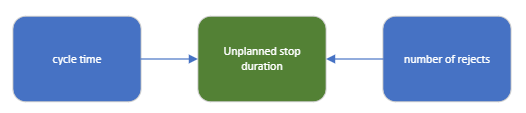

### Confoundings

Confounding refers to a situation where the relationship between the predictor variables (independent variables) and the response variable (dependent variable) is influenced or distorted by the presence of an additional variable, known as a confounding variable. In the context of the gamma distribution and linear models for predicting unplanned stops using cycle times and production counters, it is important to consider the potential confounding factors that may impact the relationship.

One potential confounding factor in this scenario could be the effect of other external factors or variables that influence both the cycle times, production counters, and the occurrence of unplanned stops. These confounding variables might include factors such as equipment reliability, environmental conditions, operator skill levels, or changes in production processes.

In the context of the described models for predicting unplanned stops using cycle times and production counters, it is important to consider the potential types of confounding that may be present. Let's examine three types of confounding: pipe confounding, fork confounding, and collider confounding.

1. Pipe Confounding:
Pipe confounding occurs when a variable lies on the causal pathway between the predictor variables and the outcome variable. In this scenario, a variable, let's say "equipment reliability," could act as a pipe confounder. It influences both the cycle times and the occurrence of unplanned stops. For example, if the equipment is unreliable, it can lead to longer cycle times and a higher likelihood of unplanned stops. If "equipment reliability" is not accounted for in the models, it can introduce confounding and bias the relationship between the predictor variables and unplanned stops.

2. Fork Confounding:
Fork confounding arises when two distinct causes affect both the predictor variables and the outcome variable independently. In this case, an external factor such as "environmental conditions" could act as a fork confounder. For instance, extreme temperature or humidity can affect both cycle times and the occurrence of unplanned stops. If "environmental conditions" are not considered as a confounding variable, it may lead to spurious associations or distorted effects of the predictor variables on unplanned stops.

3. Collider Confounding:
Collider confounding occurs when the predictor variables are influenced by a common effect, leading to a spurious association between them. For instance, a variable such as "operator skill level" might act as a collider. If highly skilled operators tend to work on specific production runs with longer cycle times, and those specific runs also have a higher likelihood of experiencing unplanned stops, it can create a collider scenario. If the models do not account for "operator skill level" as a confounding variable, it may lead to misleading or biased estimates of the relationship between cycle times, production counters, and unplanned stops.


## 2. Data preprocessing

Data used to this project came from the factory's MES system in form of three CSV files:
- states.csv,
- counters.csv,
- cycle_times.csv

that contain information about production counters, line's states during production runtime and produced items' cycle times for March and a part of April. CSV files have been prepared using SQL queries to the MES database.

There has been applied a division into the equal time windows (6 hours), in which unplanned stops times, production counters and cycle times are analysed. This particular length of the time window corresponds to the half of the production shift and provides the proper data granularity.

In [9]:
START_DATETIME, END_DATETIME = pd.to_datetime("2022-03-04 18:00:00 +01:00"), pd.to_datetime("2022-04-06 06:00:00+01:00")
START_DATETIME_BREAK, END_DATETIME_BREAK = pd.to_datetime("2022-03-29 06:00:00+01:00"), pd.to_datetime("2022-04-02 06:00:00+01:00")

### States

States' data consists of 4 columns:
- state id,
- start time,
- end time,
- state tag (can be RUN, MICROSTOP, UNPLANNED STOP and many more).

Data is filtered so it contains only RUN state and unscheduled stoppages.

In [10]:
states_df = pd.read_csv('states.csv', delimiter=';')
states_df.head()

,id,time_from,time_to,tag
0,6312581,2022-03-04 09:18:19 +01:00,2022-03-04 09:18:48 +01:00,RUN
1,6312619,2022-03-04 09:20:04 +01:00,2022-03-04 09:20:41 +01:00,RUN
2,6312655,2022-03-04 09:21:51 +01:00,2022-03-04 09:23:02 +01:00,RUN
3,6313787,2022-03-04 09:30:17 +01:00,2022-03-04 10:25:31 +01:00,RUN
4,6313869,2022-03-04 10:27:54 +01:00,2022-03-04 10:28:13 +01:00,RUN


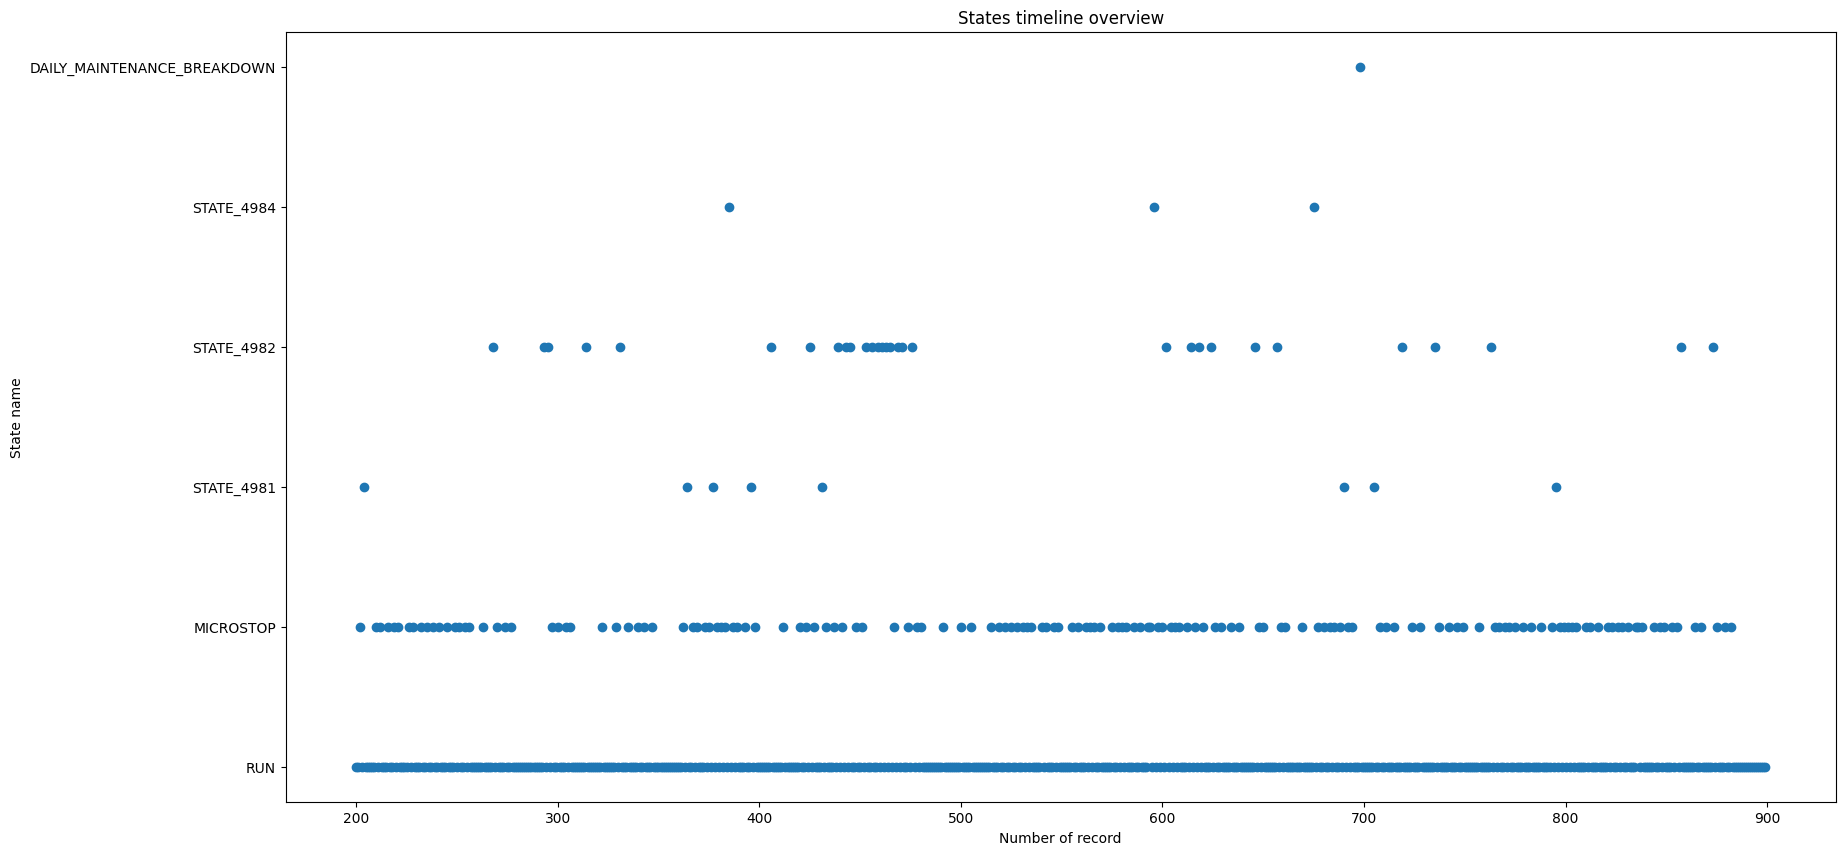

In [11]:
plt.figure(figsize=(20, 10))
plt.scatter(np.arange(200, 900, 1), states_df['tag'][200:900])
plt.title('States timeline overview')
plt.xlabel('Number of record')
plt.ylabel('State name')
plt.show()

In [12]:
df = states_df.copy()
df['time_from_dt'] = pd.to_datetime(df['time_from'])
df['time_to_dt'] = pd.to_datetime(df['time_to'])

t1 = START_DATETIME
i = 0
n = 0
data_states = {}
last_period = None

while True:
    t1 = START_DATETIME + pd.DateOffset(hours=6 * i)
    t2 = START_DATETIME + pd.DateOffset(hours=6 * (i + 1))

    if t1 > END_DATETIME:
        break

    if t1 > START_DATETIME_BREAK and t1 < END_DATETIME_BREAK:
        i += 1
        
        continue

    period = df.copy()
    period = period[period["time_from_dt"] >= t1]
    period = period[period["time_from_dt"] < t2]

    if len(period) > 0:
        period["period_end_dt"] = t2
        period["state_end_dt"] = period[['time_to_dt', 'period_end_dt']].min(axis=1)
        period["interval"] = period["state_end_dt"].apply(lambda x: x.timestamp()) - period["time_from_dt"].apply(lambda x: x.timestamp())
        interval = period["interval"].sum()
        unplanned_stop_time = period[period["tag"] != "RUN"]["interval"].sum()
        last_period = period

    else:
        time_from_dt, time_to_dt, period_end_dt, tag = last_period.iloc[-1]["time_from_dt"], last_period.iloc[-1]["time_to_dt"], last_period.iloc[-1]["period_end_dt"], last_period.iloc[-1]["tag"]
        state_end_dt = min([time_to_dt, period_end_dt])
        interval = state_end_dt.timestamp() - time_from_dt.timestamp()
        unplanned_stop_time = 0 if tag == "RUN" else interval

    data_states[n + 1] = unplanned_stop_time / interval
    i += 1
    n += 1

print(data_states)

{1: 0.010844516741222719, 2: 0.0003084832904884319, 3: 0.0060880153070099145, 4: 0.011596946926217384, 5: 0.01948765396403169, 6: 0.008104073363190446, 7: 0.014564831261101243, 8: 0.012224675534492972, 9: 0.01012130108939195, 10: 0.006129641926750779, 11: 0.009423924608603132, 12: 0.003127967379768754, 13: 0.011220758403045634, 14: 0.03621314019658562, 15: 0.0024712193357844616, 16: 0.008766894536346083, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.006773969430291802, 21: 0.0021759259259259258, 22: 0.0023784138440088574, 23: 0.018518518518518517, 24: 0.022873557104101282, 25: 0.006493184634448575, 26: 0.0, 27: 0.005652848592329861, 28: 0.00743043844856661, 29: 0.00847175289134263, 30: 0.02703769488849418, 31: 0.0008060453400503779, 32: 0.008247422680412371, 33: 0.007497768521273431, 34: 0.005601493731661776, 35: 0.03038445638693675, 36: 0.004104865634064912, 37: 0.010499065151733065, 38: 0.002914743745445713, 39: 0.014702202202202202, 40: 0.008934810821603275, 41: 0.0065540831459599104, 42: 0.0030

### Counters

Counters table contains information about production quantity grouped by production hours, there are two types of counters:
   - PRODUCTION (amount of good pieces),
   - REJECT (production waste)

In [13]:
counters_df = pd.read_csv('counters.csv', delimiter=';')
counters_df.head()

,id,value,prod_hour,tag
0,30738538,54.000,2022-03-04 09:00:00 +01:00,PRODUCTION
1,30739005,50.333,2022-03-04 09:00:00 +01:00,REJECT
2,30738341,33.000,2022-03-04 09:00:00 +01:00,PRODUCTION
3,30739158,36.333,2022-03-04 09:00:00 +01:00,REJECT
4,30738658,60.000,2022-03-04 09:00:00 +01:00,PRODUCTION


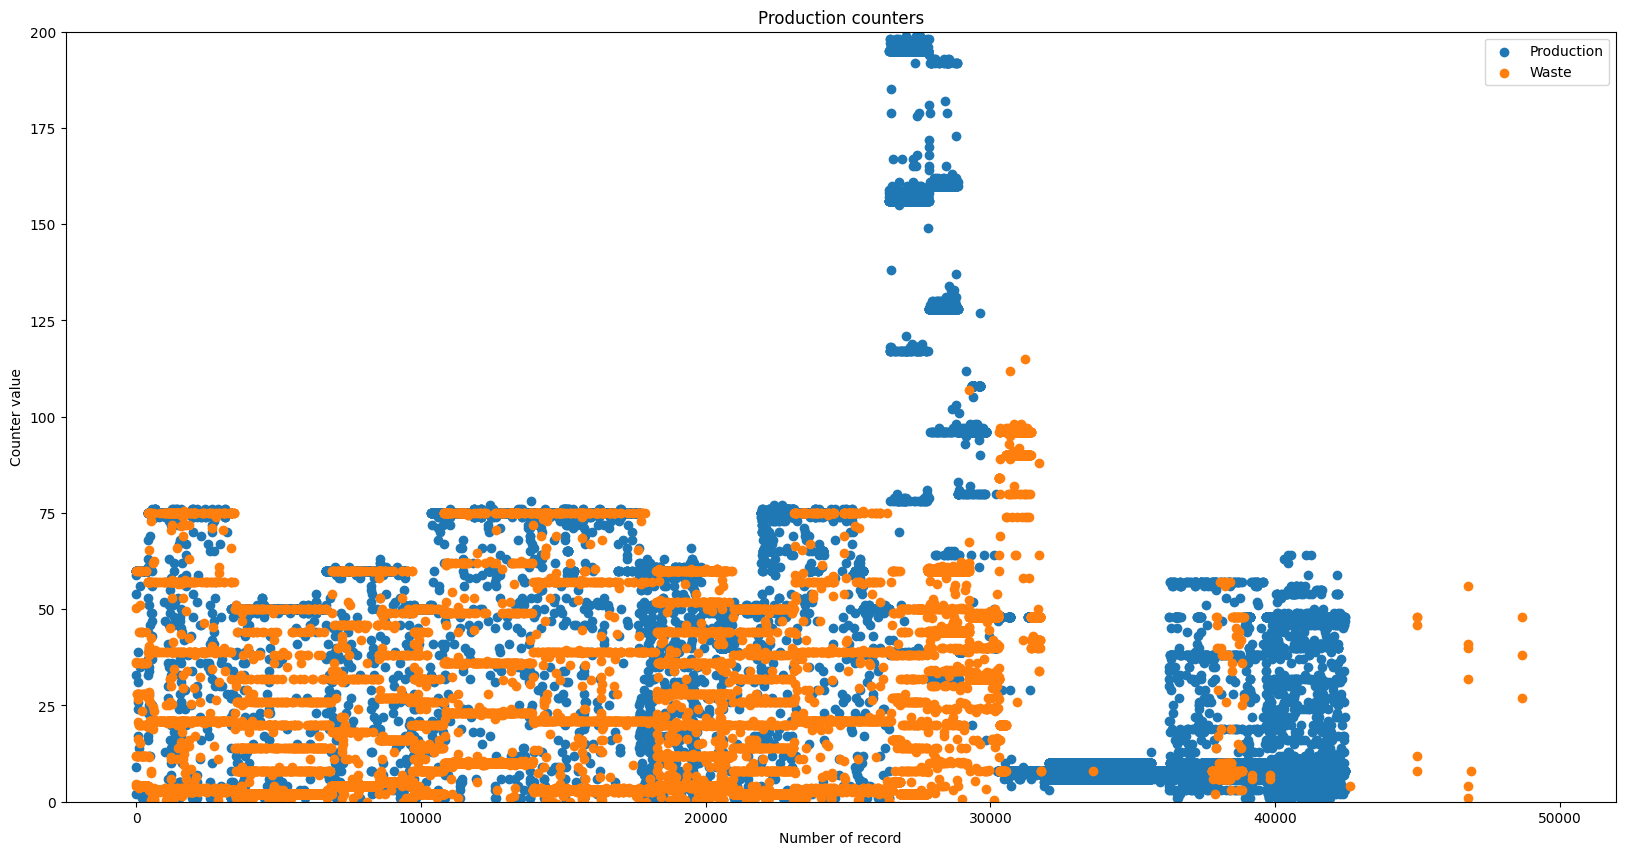

In [26]:
plt.figure(figsize=(20, 10))
production = counters_df.loc[counters_df['tag']=='PRODUCTION']['value']
reject = counters_df.loc[counters_df['tag']=='REJECT']['value']
production_x = np.arange(1, len(production) + 1, 1)
reject_x = np.arange(1, len(reject) + 1, 1)
plt.scatter(production_x, production, label='Production')
plt.scatter(reject_x, reject, label='Waste')
plt.title('Production counters')
plt.xlabel('Number of record')
plt.ylabel('Counter value')
plt.ylim([0, 200])
plt.legend()
plt.show()

In [30]:
df = counters_df.copy()
df['prod_hour_dt'] = pd.to_datetime(df['prod_hour'])
data_counters = {}
t1 = START_DATETIME
i = 0
n = 0
last_period = None

while True:
    t1 = START_DATETIME + pd.DateOffset(hours=6 * i)
    t2 = START_DATETIME + pd.DateOffset(hours=6 * (i + 1))

    if t1 > END_DATETIME:
        break

    if t1 > START_DATETIME_BREAK and t1 < END_DATETIME_BREAK:
        i += 1
        
        continue

    period = df.copy()
    period = period[period["prod_hour_dt"] >= t1]
    period = period[period["prod_hour_dt"] < t2]
    data_counters[n + 1] = period["value"].sum()
    i += 1
    n += 1

print(data_counters)

{1: 9985.5, 2: 23695.0, 3: 23308.5, 4: 22002.5, 5: 21815.5, 6: 25687.5, 7: 24778.0, 8: 21917.0, 9: 16571.5, 10: 24083.5, 11: 5742.0, 12: 16729.0, 13: 16703.0, 14: 11961.0, 15: 13784.0, 16: 15980.0, 17: 17258.0, 18: 17677.0, 19: 12923.0, 20: 16822.0, 21: 18078.0, 22: 13744.0, 23: 14827.0, 24: 19480.0, 25: 20633.0, 26: 21540.0, 27: 11037.0, 28: 18478.0, 29: 20943.0, 30: 19683.0, 31: 9337.0, 32: 9164.0, 33: 14023.0, 34: 16915.0, 35: 4007.5, 36: 26831.5, 37: 17461.0, 38: 25808.5, 39: 19642.0, 40: 26382.0, 41: 25745.5, 42: 20348.0, 43: 23728.5, 44: 26340.5, 45: 18580.0, 46: 21385.5, 47: 19676.0, 48: 24223.5, 49: 25903.5, 50: 12092.5, 51: 22630.0, 52: 20035.0, 53: 18892.5, 54: 25909.0, 55: 21899.5, 56: 26227.0, 57: 23640.0, 58: 26312.0, 59: 12989.834, 60: 16032.999000000002, 61: 8422.994999999999, 62: 1830.667, 63: 16386.331000000002, 64: 14514.0, 65: 16853.669, 66: 6010.332, 67: 14916.333999999999, 68: 8762.663, 69: 12808.002, 70: 7736.6669999999995, 71: 0.0, 72: 0.0, 73: 0.0, 74: 0.0, 75: 

### Cycle times

Third file stores information about items' cycle times from which target speed can be calculated simply. Production orders' duration is provided here as well.

In [31]:
cycle_times_df = pd.read_csv('cycle_times.csv', delimiter=';')
cycle_times_df.head()

,start_time,end_time,cycle_time_s
0,2022-03-04 20:20:20 +01:00,2022-03-06 17:58:55 +01:00,0.8
1,2022-03-06 17:59:33 +01:00,2022-03-07 05:31:12 +01:00,0.8
2,2022-03-07 09:35:57 +01:00,2022-03-08 03:33:14 +01:00,1.2
3,2022-03-08 05:30:54 +01:00,2022-03-08 06:18:19 +01:00,1.2
4,2022-03-08 06:18:56 +01:00,2022-03-09 07:16:36 +01:00,1.2


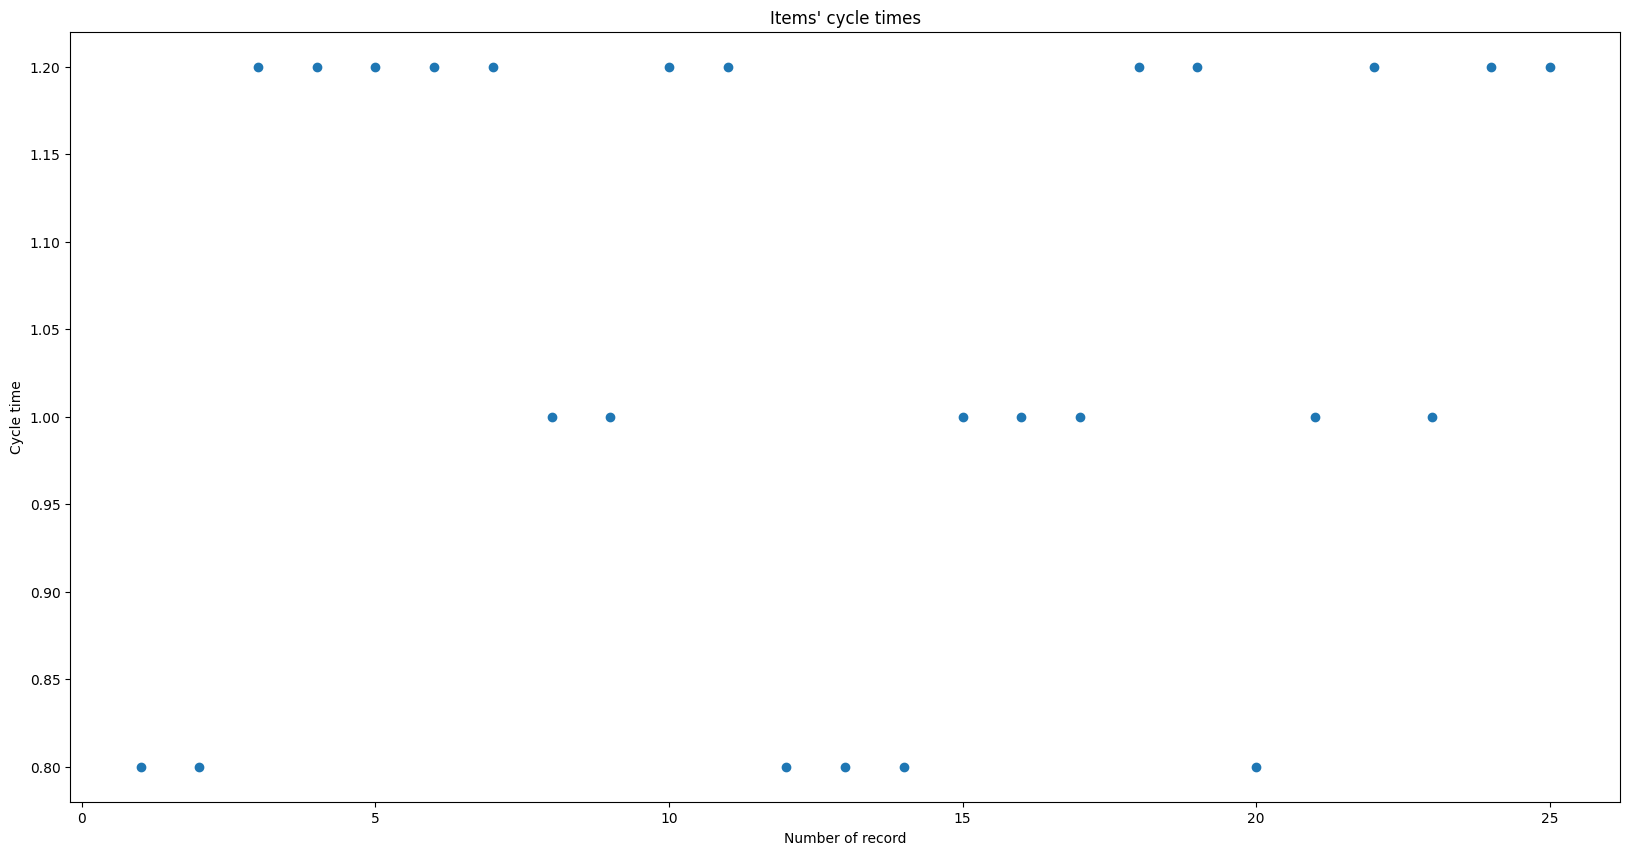

In [33]:
plt.figure(figsize=(20, 10))
cycle_times_x = np.arange(1,len(cycle_times_df['cycle_time_s']) + 1,1)
plt.scatter(cycle_times_x, cycle_times_df['cycle_time_s'])
plt.title('Items\' cycle times')
plt.xlabel('Number of record')
plt.ylabel('Cycle time')
plt.show()

In [34]:
df = cycle_times_df.copy()
df['start_time_dt'] = pd.to_datetime(df['start_time'])
df['start_time_ts'] = df['start_time_dt'].apply(lambda x: x.timestamp())
data_cycles = {}
t1 = START_DATETIME
i = 0
n = 0

while True:
    t1 = START_DATETIME + pd.DateOffset(hours=6 * i)
    t2 = START_DATETIME + pd.DateOffset(hours=6 * (i + 1))

    if t1 > END_DATETIME:
        break

    if t1 > START_DATETIME_BREAK and t1 < END_DATETIME_BREAK:
        i += 1
        
        continue

    period = df.copy()
    period = period[period["start_time_dt"] >= t1]
    period = period[period["start_time_dt"] < t2]

    if len(period) > 0:
        weights = []
        cycle_time = 0

        for idx in range(len(period)):
            if idx == len(period) - 1:
                weight = t2.timestamp() - period.iloc[idx]["start_time_ts"]

            else:
                weight = period.iloc[idx + 1]["start_time_ts"] - period.iloc[idx]["start_time_ts"]

            weights.append(weight)
            time = period.iloc[idx]["cycle_time_s"]
            cycle_time = cycle_time + weight * time

        data_cycles[n + 1] = cycle_time / sum(weights)

    else:
        data_cycles[n + 1] = data_cycles[n]

    i += 1
    n += 1

print(data_cycles)

{1: 0.8, 2: 0.8, 3: 0.8, 4: 0.8, 5: 0.8, 6: 0.8, 7: 0.8, 8: 0.8, 9: 0.8, 10: 0.8, 11: 1.2, 12: 1.2, 13: 1.2, 14: 1.2, 15: 1.2, 16: 1.2, 17: 1.2, 18: 1.2, 19: 1.2, 20: 1.2, 21: 1.2, 22: 1.0, 23: 1.0, 24: 1.0, 25: 1.0, 26: 1.0, 27: 1.0, 28: 1.0, 29: 1.0, 30: 1.0, 31: 1.2, 32: 1.2, 33: 1.2, 34: 1.2, 35: 0.8, 36: 0.8, 37: 0.8, 38: 0.8, 39: 0.8, 40: 0.8, 41: 0.8, 42: 0.8, 43: 0.8, 44: 0.8, 45: 0.8, 46: 0.8, 47: 0.8, 48: 0.8, 49: 0.8, 50: 0.8, 51: 0.8, 52: 0.8, 53: 0.8, 54: 0.8, 55: 0.8, 56: 0.8, 57: 0.8, 58: 0.8, 59: 1.0, 60: 1.0, 61: 1.0, 62: 1.0, 63: 1.0, 64: 1.0, 65: 1.0, 66: 1.0, 67: 1.0, 68: 1.0, 69: 1.0, 70: 1.2, 71: 1.2, 72: 1.2, 73: 1.2, 74: 1.2, 75: 1.2, 76: 1.2, 77: 1.2, 78: 1.2, 79: 1.2, 80: 1.2, 81: 1.2, 82: 1.2, 83: 0.8, 84: 0.8, 85: 0.8, 86: 0.8, 87: 0.8, 88: 0.8, 89: 0.8, 90: 0.8, 91: 0.8, 92: 0.8, 93: 0.8, 94: 1.0, 95: 1.0, 96: 1.2, 97: 1.2, 98: 1.2, 99: 1.2, 100: 1.2, 101: 1.2, 102: 1.2, 103: 1.2, 104: 1.2, 105: 1.2, 106: 1.2, 107: 1.2, 108: 1.2, 109: 1.2, 110: 1.2, 111: 1.

### Omitting empty values

In [36]:
data_states_list = []
data_counters_list = []
data_cycles_list = []

for i in data_states:
    if data_states[i] > 0 and data_counters[i] > 0 and data_cycles[i] > 0:
        data_states_list.append(data_states[i])
        data_counters_list.append(data_counters[i])
        data_cycles_list.append(data_cycles[i])

## 3. Model

### Models specification

- Model 1 (Exponential model)

It takes into account a linear relationship between unplanned stops and cycle times. If provides simplicity, interpretability and clear understanding of the relationship.


- Model 2 (Gamma model)

It also takes into account a linear relationship between unplanned stops and cycle times, but takes into consideration production counters as well. Gamma distribution provides non-negativity as there is need for predicted values to be non-negative. The gamma distribution is suitable for modeling positive continuous variables, such as durations. The gamma distribution allows for capturing the distributional characteristics of the data, particularly the right-skewness typically observed in duration or time-to-event data.

### Difference between models

In Model 1 there are analyzed effects of cycle times on unplanned stops durations. There is an assumption that these durations depend only on this one variable.

Model 2 is an extension of Model 1 - it additionally considers the production counters, particularly rejects number over time.

Both models may evaluate the impact of these variables on unplanned stops durations.

### Difference between models justification

Such specified models will be a perfect study object since the only difference between them is in the fact if the production counters have been taken into consideration. From the theoretical point of view, it makes sense to take this variable into account since the number of rejects is correlated with unplanned stops.

### Models description

Input data
- number of samples,
- unplanned stops times,
- number of rejects (used only in Model 2),
- cycle times,
- gamma and exponential distribution priors.

Parameters ($\alpha$, $\beta$ and optionally $\gamma$):
- coefficients of linear model,
- parameters of distributions.

Model 1 formula:
$$unplanned\_stops\_time = exponential(\alpha + \beta * cycle\_times)$$

Model 2 formula:
$$unplanned\_stops\_time = gamma(\alpha, \beta * number\_of\_rejects + \gamma * cycle\_times)$$

## 4. Prior predictive checks for model 2 (Exponential)

Linear model was chosen to predict unplanned stops because it aligns with the assumptions and characteristics of the problem at hand. The decision to use a linear model is based on the following considerations:

1. Simplicity and Interpretability: A linear model provides a straightforward and interpretable relationship between the predictor variable ("cycle time") and the output of the designed system. The coefficients in the linear model have direct interpretations: the intercept represents the expected unplanned stop time when the cycle time is zero, and the slope represents the change in the expected unplanned stop time per unit increase in the cycle time. This simplicity allows for easy understanding and communication of the results.

2. Linearity Assumption: assumptionhas been made that the relationship between cycle time and unplanned stops is linear. While this assumption may not hold in all cases, it is reasonable to assume linearity when there is no strong evidence or prior knowledge suggesting a non-linear relationship. By assuming linearity, the linear model captures the overall trend and direction of the relationship.

3. Availability and Implementation: Linear models are widely implemented and available in various statistical software packages. They are computationally efficient and can handle large datasets. This availability and ease of implementation make linear models a practical choice, allowing to quickly analyze and interpret the relationship between the variables.

4. Initial Exploration: Using a linear model serves as an initial exploration to understand the basic relationship between cycle time and unplanned stops. It provides a foundation for further analysis and model refinement. If the linear model reveals a meaningful relationship and performs adequately, it can provide valuable insights and guide decision-making.

5. It's important to acknowledge that a linear model might not capture all the complexities or non-linear relationships that exist in the data. If there are indications or prior knowledge suggesting non-linear patterns, alternative modeling approaches such as polynomial regression, splines, or machine learning algorithms may be more appropriate. However, the linear model serves as a reasonable starting point to understand the relationship between cycle time and unplanned stops and can provide valuable insights within its assumptions and limitations.

In [39]:
exp_ppc = CmdStanModel(stan_file="exp_ppc.stan")

16:50:58 - cmdstanpy - INFO - compiling stan file C:\Users\gcyburt\Documents\repos\priv\AGH-Data-Analytics\Data-Analytics\Project\exp_ppc.stan to exe file C:\Users\gcyburt\Documents\repos\priv\AGH-Data-Analytics\Data-Analytics\Project\exp_ppc.exe
16:51:19 - cmdstanpy - INFO - compiled model executable: C:\Users\gcyburt\Documents\repos\priv\AGH-Data-Analytics\Data-Analytics\Project\exp_ppc.exe


16:51:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


16:51:33 - cmdstanpy - INFO - CmdStan done processing.


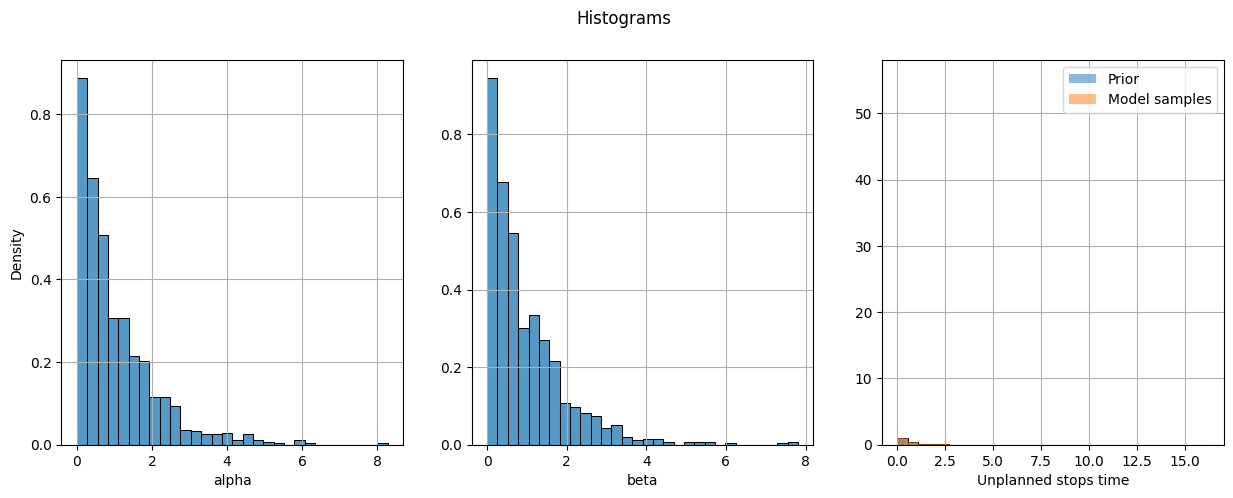

In [41]:
exp_ppc_data = {"N": len(data_states_list), "cycle_times": data_cycles_list}
exp_ppc_sim = exp_ppc.sample(data=exp_ppc_data, iter_sampling=REFRESH, iter_warmup=0, chains=1, refresh=REFRESH, fixed_param=True, seed=SEED)
exp_ppc_df = exp_ppc_sim.draws_pd()

_, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data=exp_ppc_df, x="alpha", stat="density", ax=ax[0], bins=BINS)
sns.histplot(data=exp_ppc_df, x="beta", stat="density", ax=ax[1], bins=BINS)
sns.histplot(data=exp_ppc_df, x="predicted_stop_times[1]", stat="density", ax=ax[2], bins=BINS)
ax[0].grid(), ax[1].grid(), ax[2].grid()
ax[0].set_xlabel("alpha"), ax[1].set_xlabel("beta"), ax[2].set_xlabel("Unplanned stops time")
ax[0].set_ylabel("Density"), ax[1].set_ylabel(""), ax[2].set_ylabel("")
ax[2].hist(data_states_list, bins=BINS, alpha=0.5, density=True, label="Prior")
ax[2].hist(exp_ppc_df["predicted_stop_times[1]"], bins=BINS, alpha=0.5, density=True, label="Model samples")
ax[2].legend()
plt.suptitle("Histograms")
plt.show()

Prior parameters were chosen half-empirically. There has applied standard (from literature) parameter for exponential distribution. Then there has been being modified to obtain the data similar to the observed one.

The chosen parameters make it possible to obtain the observed data.

## 5. Fitting and evaluating model 2 (Exponential)

In [42]:
exp_fit = CmdStanModel(stan_file="exp_fit.stan")

16:51:40 - cmdstanpy - INFO - compiling stan file C:\Users\gcyburt\Documents\repos\priv\AGH-Data-Analytics\Data-Analytics\Project\exp_fit.stan to exe file C:\Users\gcyburt\Documents\repos\priv\AGH-Data-Analytics\Data-Analytics\Project\exp_fit.exe
16:52:04 - cmdstanpy - INFO - compiled model executable: C:\Users\gcyburt\Documents\repos\priv\AGH-Data-Analytics\Data-Analytics\Project\exp_fit.exe


16:52:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status

chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


16:52:09 - cmdstanpy - INFO - CmdStan done processing.
16:52:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: exponential_lpdf: Inverse scale parameter is inf, but must be positive finite! (in 'C:/Users/gcyburt/Documents/repos/priv/AGH-Data-Analytics/Data-Analytics/Project/exp_fit.stan', line 19, column 4 to column 74)
Consider re-running with show_console=True if the above output is unclear!
16:52:09 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 3 divergent transitions (0.3%)
	Chain 4 had 9 divergent transitions (0.9%)
	Use function "diagnose()" to see further information.


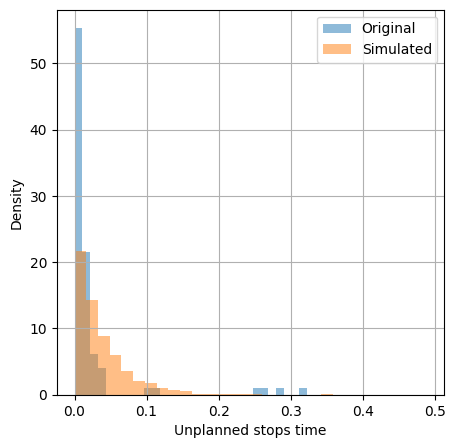

In [43]:
exp_fit_data = {"N": len(data_states_list), "unplanned_stops_times": data_states_list, "cycle_times": data_cycles_list}
exp_fit_sim = exp_fit.sample(data=exp_fit_data, seed=SEED)
exp_fit_df = exp_fit_sim.draws_pd()

plt.figure(figsize=(5, 5))
plt.hist(data_states_list, bins=BINS, alpha=0.5, density=True, label="Original")
plt.hist(exp_fit_df["predicted_stop_times[1]"], bins=BINS, alpha=0.5, density=True, label="Simulated")
plt.grid()
plt.xlabel("Unplanned stops time"), plt.ylabel("Density")
plt.legend()
plt.show()

The similarity between the prior and posterior models implies that the initial assumptions made during the modeling process were reasonable and aligned with the observed data. It also suggests that the chosen priors were not overly informative or strongly influenced the final results. While the similarity between the prior and posterior models may indicate stability and consistency in the results, it is important to note that additional analyses and model evaluation should be conducted to further assess the model's performance and suitability for predicting unplanned stops accurately.

### Fit summary

In [44]:
summary = exp_fit_sim.summary()
summary.head(6)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,215.751000,0.096002,1.229790,213.200000,216.144000,216.932000,164.0980,215.918,1.040890
alpha,19.344200,0.836074,7.597620,4.470560,20.684300,30.015000,82.5783,108.656,1.077820
beta,9.440480,0.769211,7.360450,0.579812,7.671010,24.336100,91.5625,120.477,1.077740
predicted_stop_times[1],0.037707,0.000655,0.039800,0.001722,0.025276,0.114448,3689.8000,4854.990,0.999694
predicted_stop_times[2],0.038002,0.000618,0.038779,0.002030,0.026079,0.112449,3942.9600,5188.100,0.999935
predicted_stop_times[3],0.039439,0.000659,0.039586,0.001890,0.027160,0.116857,3606.6800,4745.630,1.001320


### Marginal distributions

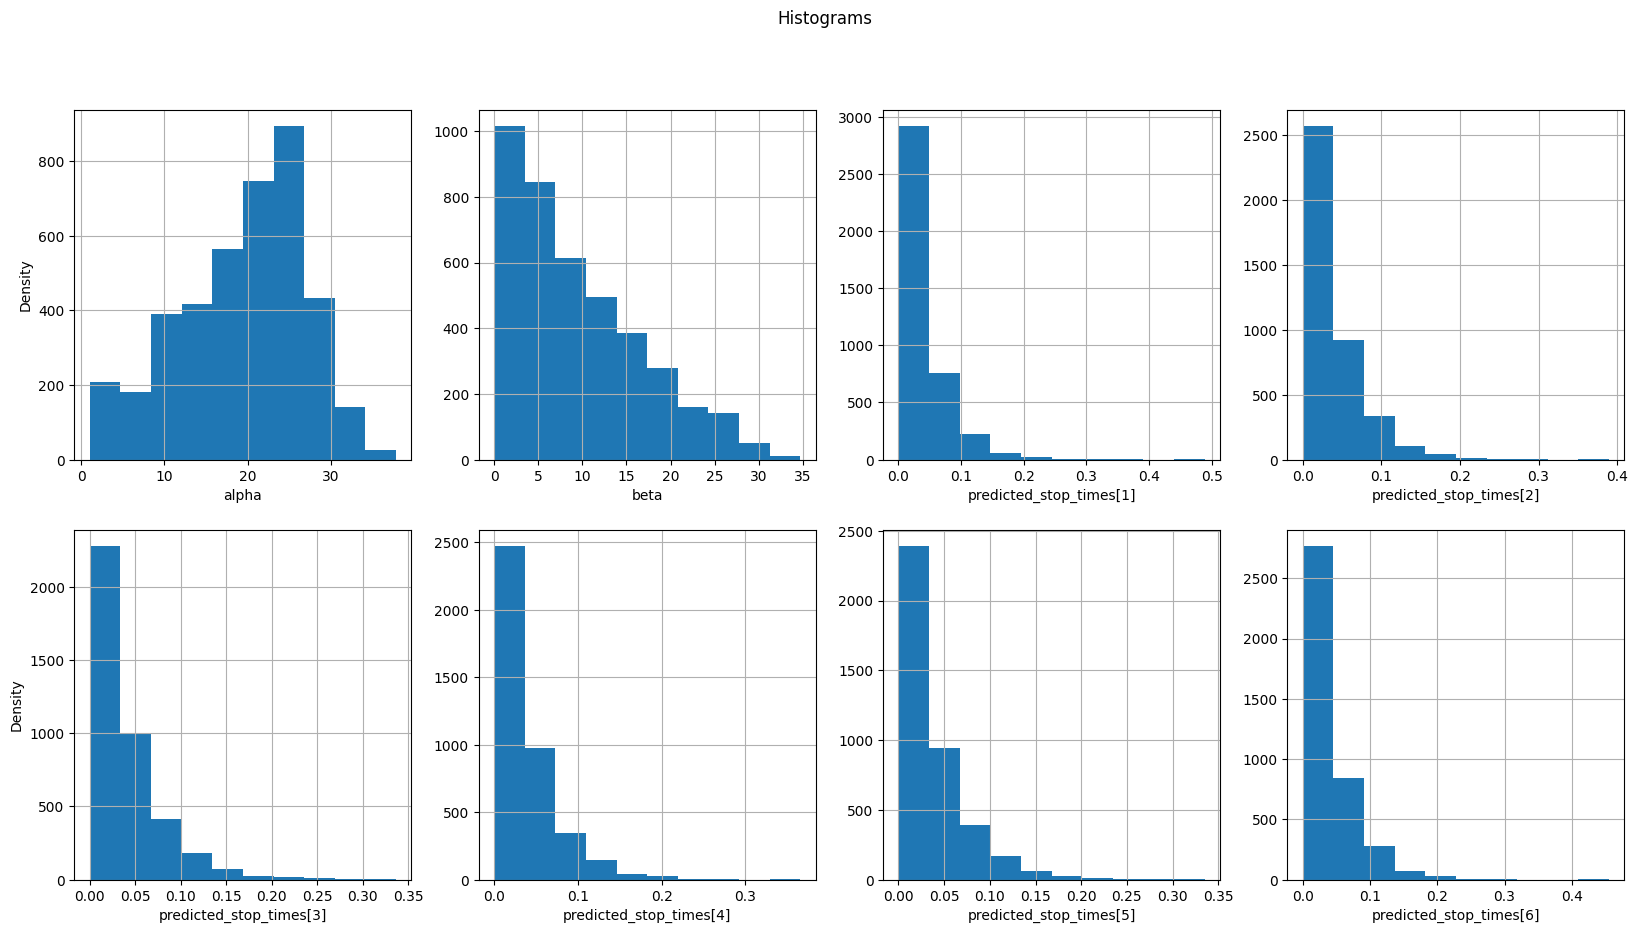

In [45]:
_, ax = plt.subplots(2, 4, figsize=(20, 10))
ax = ax.flatten()

for i, parameter in enumerate(['alpha', 'beta', 'predicted_stop_times[1]', 'predicted_stop_times[2]', 'predicted_stop_times[3]',
'predicted_stop_times[4]', 'predicted_stop_times[5]', 'predicted_stop_times[6]']):
   ax[i].grid()
   ax[i].hist(exp_fit_df[parameter])
   ax[i].set_xlabel(parameter)

   if i % 4 == 0:
      ax[i].set_ylabel('Density')

plt.suptitle('Histograms')
plt.show()

## 6. Prior predictive checks for model 1 (Gamma)

 Gamma distribution was chosen to model and predict unplanned stops because it aligns well with the characteristics and assumptions of the problem at hand. The decision to use a gamma distribution is based on the following considerations:

1. Non-Negative Predictions: It is essential to ensure that the predicted unplanned stop times are non-negative since they represent durations or quantities that cannot be negative. The gamma distribution is well-suited for this purpose as it has support for positive values only, ensuring that the predicted values are realistic and within the appropriate range.

2. Flexibility and Skewness: The gamma distribution is a versatile and widely used probability distribution for modeling positive continuous data. It can capture a wide range of shapes and allows for right-skewness, which is often observed in duration or time-to-event data. By using the gamma distribution, it is possible to effectively capture the distributional characteristics of the unplanned stop times and account for potential skewness in the data.

3. Interpretability: The parameters of the gamma distribution have meaningful interpretations. The shape parameter controls the shape of the distribution, while the scale parameter determines the overall scale or average unplanned stop time.

4. Validating Assumptions: By choosing the gamma distribution, it is assumed that the unplanned stop times follow a specific distributional form. This assumption can be further assessed and validated through model evaluation and diagnostic procedures. If the gamma distribution is found to be a good fit for the data, it provides confidence in the modeling approach and enhances the reliability of the predictions.

By considering the non-negativity of the response variable, the flexibility and skewness-capturing capability of the gamma distribution, as well as the interpretability of its parameters, we can construct a robust and appropriate model for predicting unplanned stops.

In [46]:
gamma_ppc = CmdStanModel(stan_file="gamma_ppc.stan")

16:52:12 - cmdstanpy - INFO - compiling stan file C:\Users\gcyburt\Documents\repos\priv\AGH-Data-Analytics\Data-Analytics\Project\gamma_ppc.stan to exe file C:\Users\gcyburt\Documents\repos\priv\AGH-Data-Analytics\Data-Analytics\Project\gamma_ppc.exe
16:52:29 - cmdstanpy - INFO - compiled model executable: C:\Users\gcyburt\Documents\repos\priv\AGH-Data-Analytics\Data-Analytics\Project\gamma_ppc.exe


16:52:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


16:52:30 - cmdstanpy - INFO - CmdStan done processing.
16:52:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_ppc_model_namespace::write_array: predicted_stop_times[1] is 1.4822, but must be less than or equal to 1.000000 (in 'C:/Users/gcyburt/Documents/repos/priv/AGH-Data-Analytics/Data-Analytics/Project/gamma_ppc.stan', line 14, column 2 to column 51)
	Exception: gamma_ppc_model_namespace::write_array: predicted_stop_times[1] is 4.31972, but must be less than or equal to 1.000000 (in 'C:/Users/gcyburt/Documents/repos/priv/AGH-Data-Analytics/Data-Analytics/Project/gamma_ppc.stan', line 14, column 2 to column 51)
	Exception: gamma_ppc_model_namespace::write_array: predicted_stop_times[14] is 1.32559, but must be less than or equal to 1.000000 (in 'C:/Users/gcyburt/Documents/repos/priv/AGH-Data-Analytics/Data-Analytics/Project/gamma_ppc.stan', line 14, column 2 to column 51)
	Exception: gamma_ppc_model_namespace::write_array: predicted_stop_times[8] is 2.509

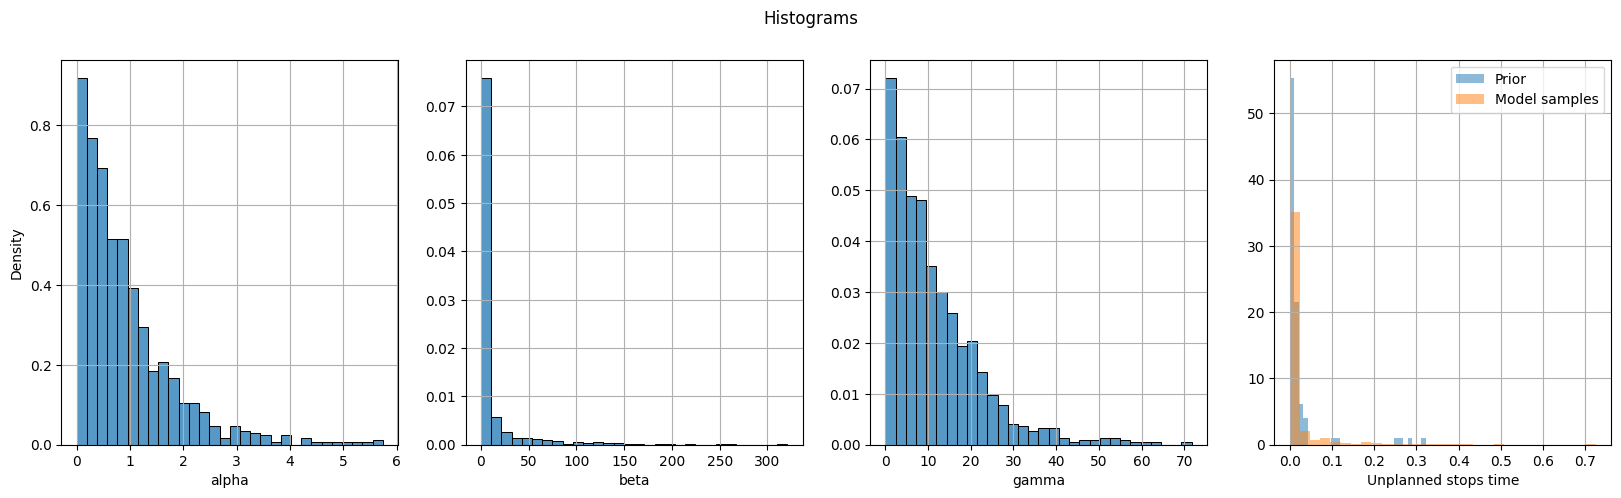

In [47]:
gamma_ppc_data = {"N": len(data_states_list), "rejects": data_counters_list, "cycle_times": data_cycles_list,
                  "alpha_shape": 1, "alpha_scale": 1, "beta_shape": 0.1, "beta_scale": 0.01, "gamma_shape": 1, "gamma_scale": 0.1}
gamma_ppc_sim = gamma_ppc.sample(data=gamma_ppc_data, iter_sampling=REFRESH, iter_warmup=0, chains=1, fixed_param=True, seed=SEED)
gamma_ppc_df = gamma_ppc_sim.draws_pd()

_, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.flatten()
sns.histplot(data=gamma_ppc_df, x="alpha", stat="density", ax=ax[0], bins=BINS)
sns.histplot(data=gamma_ppc_df, x="beta", stat="density", ax=ax[1], bins=BINS)
sns.histplot(data=gamma_ppc_df, x="gamma", stat="density", ax=ax[2], bins=BINS)
ax[3].hist(data_states_list, bins=BINS, alpha=0.5, density=True, label="Prior")
ax[3].hist(gamma_ppc_df["predicted_stop_times[1]"], bins=BINS, alpha=0.5, density=True, label="Model samples")
ax[0].grid(), ax[1].grid(), ax[2].grid(), ax[3].grid()
ax[0].set_xlabel("alpha"), ax[1].set_xlabel("beta"), ax[2].set_xlabel("gamma"), ax[3].set_xlabel("Unplanned stops time")
ax[0].set_ylabel("Density"), ax[1].set_ylabel(""), ax[2].set_ylabel(""), ax[3].set_ylabel("")
ax[3].legend()
plt.suptitle("Histograms")
plt.show()

Prior parameters were chosen half-empirically. There have applied standard (from literature) parameters such as shape=1 and scale=1 for gamma distribution. Then there have been being modified to obtain the data similar to the observed one.

The chosen parameters make it possible to obtain the observed data.

## 7. Fitting and evaluating model 1 (Gamma)

In [72]:
gamma_fit = CmdStanModel(stan_file="gamma_fit.stan")

17:15:37 - cmdstanpy - INFO - compiling stan file C:\Users\gcyburt\Documents\repos\priv\AGH-Data-Analytics\Data-Analytics\Project\gamma_fit.stan to exe file C:\Users\gcyburt\Documents\repos\priv\AGH-Data-Analytics\Data-Analytics\Project\gamma_fit.exe
17:15:55 - cmdstanpy - INFO - compiled model executable: C:\Users\gcyburt\Documents\repos\priv\AGH-Data-Analytics\Data-Analytics\Project\gamma_fit.exe


17:15:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |█████████ | 00:01 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


17:15:57 - cmdstanpy - INFO - CmdStan done processing.
17:15:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'C:/Users/gcyburt/Documents/repos/priv/AGH-Data-Analytics/Data-Analytics/Project/gamma_fit.stan', line 23, column 2 to column 39)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'C:/Users/gcyburt/Documents/repos/priv/AGH-Data-Analytics/Data-Analytics/Project/gamma_fit.stan', line 23, column 2 to column 39)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'C:/Users/gcyburt/Documents/repos/priv/AGH-Data-Analytics/Data-Analytics/Project/gamma_fit.stan', line 23, column 2 to column 39)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'C:/Users/gcyburt/Documents/repos/priv/AGH-Data-Analytics/Data-Analytics/Project/gamma_fit.stan', line 23, column 2 to column 39)
	Exception: gamma_lpdf: Random variable is 

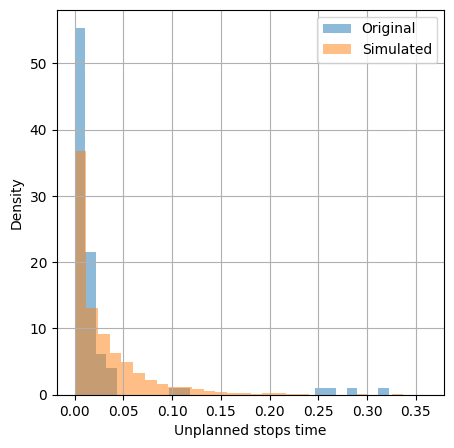

In [73]:
gamma_fit_data = {"N": len(data_states_list), "unplanned_stop_times": data_states_list, "rejects": data_counters_list, "cycle_times": data_cycles_list,
                  "alpha_shape": 1, "alpha_scale": 1, "beta_shape": 0.1, "beta_scale": 0.01, "gamma_shape": 1, "gamma_scale": 0.1}
gamma_fit_sim = gamma_fit.sample(data=gamma_fit_data, seed=SEED)
gamma_fit_df = gamma_fit_sim.draws_pd()

plt.figure(figsize=(5, 5))
plt.hist(data_states_list, bins=BINS, alpha=0.5, density=True, label="Original")
plt.hist(gamma_fit_df["predicted_stop_times[1]"], bins=BINS, alpha=0.5, density=True, label="Simulated")
plt.xlabel("Unplanned stops time"), plt.ylabel("Density")
plt.grid()
plt.legend()
plt.show()

The similarity between the prior and posterior models in terms of the gamma distribution implies that the initial assumptions made about the distributional form and parameterization were appropriate and well-suited for modeling the unplanned stop times. It also suggests that the chosen priors for the gamma distribution were not overly informative or strongly influenced by the observed data.

### Fit summary

In [50]:
summary = gamma_fit_sim.summary()
summary.head(6)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,249.725000,5.716340e-02,1.407850,2.469750e+02,2.500740e+02,251.315000,606.566,477.987,1.002570
alpha,0.591835,2.529290e-03,0.071851,4.816530e-01,5.864610e-01,0.720605,807.004,635.937,1.009610
beta,0.000002,1.472200e-07,0.000006,6.768970e-19,1.594820e-08,0.000012,1705.190,1343.730,1.001810
gamma,24.094900,1.511080e-01,4.417560,1.727590e+01,2.370760e+01,31.567600,854.654,673.486,1.004110
predicted_stop_times[1],0.030701,6.435300e-04,0.040020,2.443780e-04,1.570500e-02,0.112782,3867.350,3047.560,0.999317
predicted_stop_times[2],0.031968,7.035250e-04,0.043155,2.559570e-04,1.617250e-02,0.116721,3762.780,2965.160,0.999288


### Marginal distributions

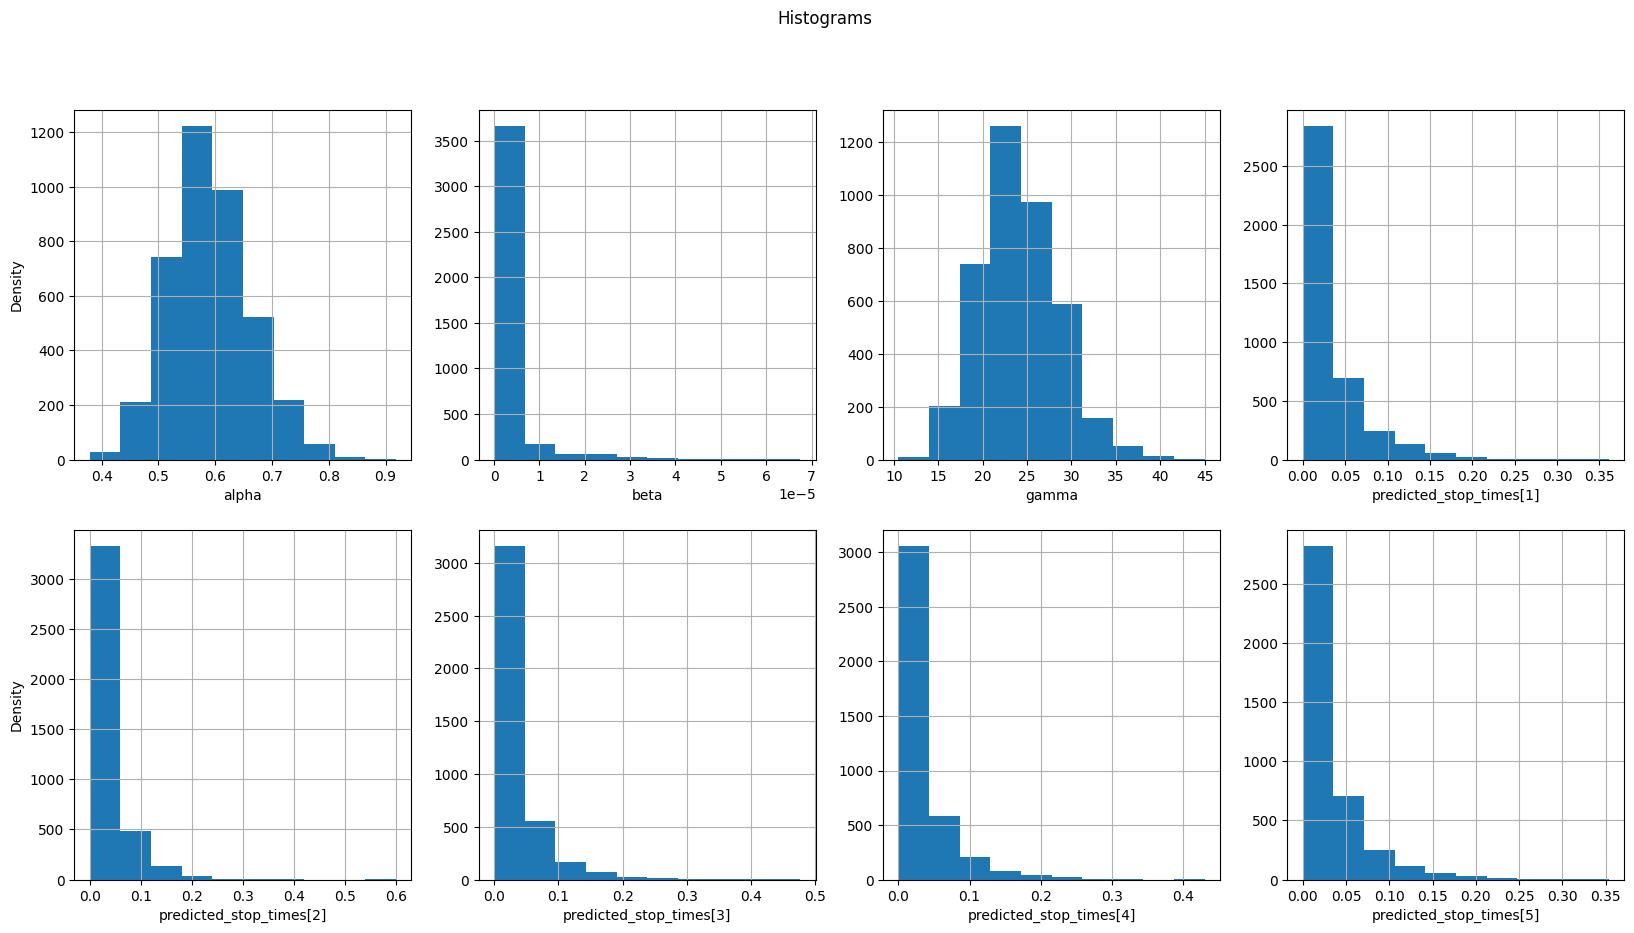

In [51]:
_, ax = plt.subplots(2, 4, figsize=(20, 10))
ax = ax.flatten()

for i, parameter in enumerate(['alpha', 'beta', 'gamma', 'predicted_stop_times[1]', 'predicted_stop_times[2]', 'predicted_stop_times[3]',
'predicted_stop_times[4]', 'predicted_stop_times[5]']):
   ax[i].grid()
   ax[i].hist(gamma_fit_df[parameter])
   ax[i].set_xlabel(parameter)

   if i % 4 == 0:
      ax[i].set_ylabel('Density')

plt.suptitle('Histograms')
plt.show()

## 8. Models comparison

WAIC


C:\Users\gcyburt\AppData\Roaming\Python\Python311\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\Users\gcyburt\AppData\Roaming\Python\Python311\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
Model 2,0,249.615919,4.674397,0.000000,1.0,18.189997,0.000000,True,log
Model 1,1,238.330252,3.049154,11.285667,0.0,16.413423,3.574024,True,log


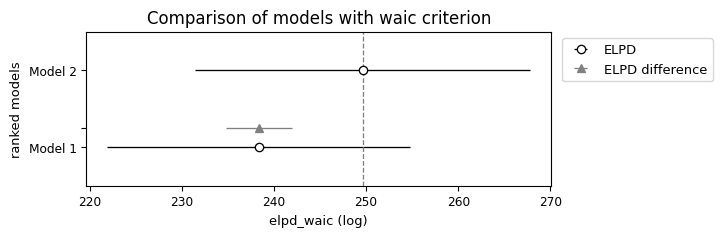





LOO


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Model 2,0,249.451075,4.839241,0.000000,1.0,18.266306,0.000000,False,log
Model 1,1,238.315720,3.063687,11.135355,0.0,16.419863,3.594431,False,log


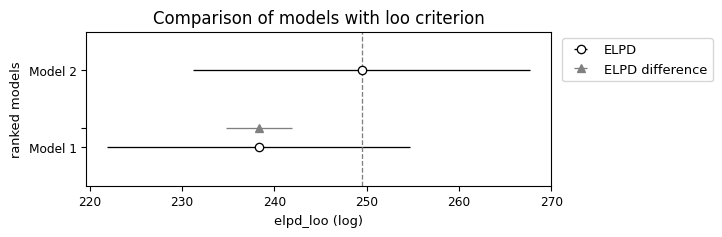

In [54]:
compare_dict = {
    "Model 1": az.from_cmdstanpy(posterior=exp_fit_sim),
    "Model 2": az.from_cmdstanpy(posterior=gamma_fit_sim)
}

for information_criteria in ["waic", "loo"]:
    diff = az.compare(compare_dict=compare_dict, ic=information_criteria)
    print(f"{information_criteria.upper()}")
    print("="*100)
    display(diff)
    ax = az.plot_compare(diff)
    ax.set_title(f"Comparison of models with {information_criteria} criterion")
    plt.show()
    print("="*100)

    if information_criteria == "waic":
        print('\n\n\n')

Watanabe-Akaike information criterion (WAIC) ratio analysis
- Model 2 has a "rank" of 0, indicating that it is better than Model 1,
- "weight" represents the weight assigned to each model based on WAIC comparisons. For Model 2 the weight is 1.0, which implies a higher probability that the model is well-fitted to the data.

To sum up, Model 2 is better fitted to the data and more reliable according to the Watanabe-Akaike information Criterion, but the difference is not significant since many parameter values are higher in this model, such as standard error.

Leave-One-Out (LOO) ratio analysis
- Model 2 has a "rank" of 0, indicating that it is better than Model 1,
- "weight" represents the weight assigned to each model based on WAIC comparisons. For Model 2 the weight is 1.0, which implies a higher probability that the model is well-fitted to the data,
- "warning" indicates whether any warnings occurred during the calculations. Both models have a value of False, suggesting that no warnings were raised.

To sum up, Model 2 is better fitted to the data and more reliable according to the Leave-One-Out, but the difference is not significant since many parameter values are higher in this model, such as standard error.

The comparison made above using information criteria confirmed our earlier conclusions. Model 2 proved to be significantly better, showing that the impact of number of rejects is significant. After many months of contact with MES this conlusion is quite obvious and were expected.